# Variational inference with normalizing flows

1D Bayesian linear regression.

In [1]:
import jax.numpy as jnp
import jax.random as jr
from jax.scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt
from corner import corner

from flowjax.bijections import Affine
from flowjax.distributions import StandardNormal
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_key_based_loss
from flowjax.train.losses import ElboLoss

# generate observed data
data_key = jr.key(0)
w_0 = 0.5
w_1 = -0.5

n = 100
key, x_key, noise_key = jr.split(data_key, 3)
x = jr.uniform(x_key, shape=(n,)) * 4 - 2
y = w_0 + w_1 * x + jr.normal(noise_key, shape=(n,))

The likelihood is given by

\begin{equation}
    y \sim \mathcal{N}(w_0 + w_1 x, 1)\,,
\end{equation}

and the prior is,

\begin{equation}
    w_0, w_1 \sim \mathcal{N}(\mathbf{0}, \mathbf{1})
\end{equation}

In [2]:
def unormalized_posterior(w):
    likelihood = norm.logpdf(y, w[0] + x * w[1]).sum()
    prior = norm.logpdf(w).sum()  # Standard normal prior
    return (likelihood + prior).sum()

In [3]:
# define loss function
loss = ElboLoss(unormalized_posterior, num_samples=100)

# construct flow
key, flow_key, train_key = jr.split(key, 3)
flow = masked_autoregressive_flow(
    flow_key, base_dist=StandardNormal((2,)), transformer=Affine(), invert=False,
)

# train the flow variationally
flow, losses = fit_to_key_based_loss(
    train_key, flow, loss_fn=loss, learning_rate=1e-3, steps=400,
)

100%|██████████| 400/400 [00:00<00:00, 477.74it/s, loss=155]


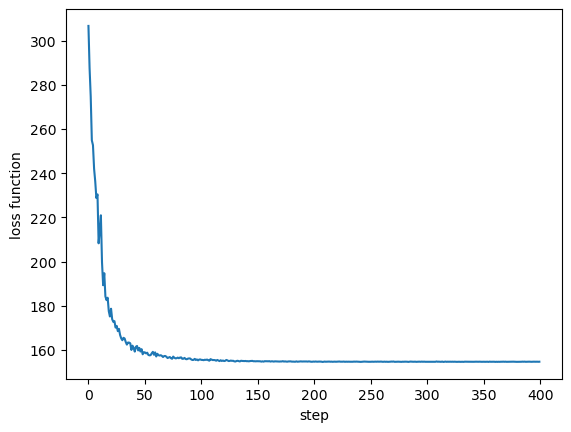

In [4]:
# plot loss function over learning
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss function')
plt.show()

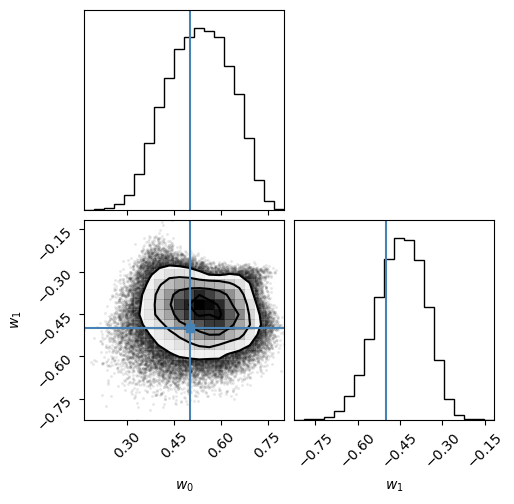

In [5]:
# sample from learned posterior
sample_key = jr.key(1)
num_samples = 100_000
samples = flow.sample(sample_key, (num_samples,))

fig = corner(np.array(samples),
             labels=[r'$w_0$', r'$w_1$'],
             truths=[w_0, w_1])

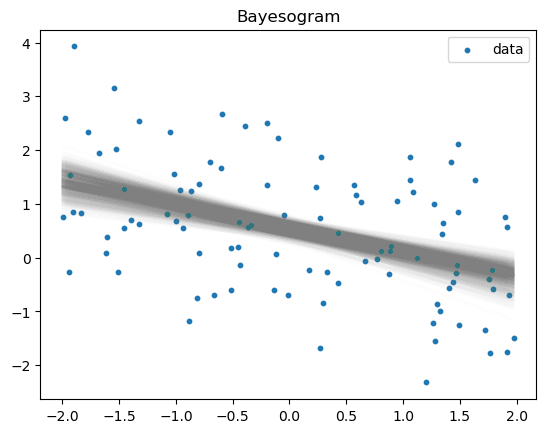

In [6]:
# poor man's Bayesogram
num_draws = 1000
draw_ndxs = np.random.choice(num_samples, num_draws)
plt.scatter(x, y, label='data', color='C0', s=10)
[plt.plot(x, samp[0] + samp[1] * x, color='grey', alpha=10. / num_draws)
 for samp in samples[draw_ndxs]];
plt.title('Bayesogram')
plt.legend()
plt.show()